### This file is used to retrieve weather data along with NEE from the ameriFLUX maize-soybean datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import os
import warnings
from sklearn import preprocessing
import scipy.stats
warnings.filterwarnings('ignore')

In [2]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = '../datasets/' + dr +  '/' + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, 'csv_outs/with_plant_soil_details/')

In [3]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)
#y = df[target].copy()
#df = df.drop(target, axis=1)

In [4]:
df_irr['DATE'] =  pd.to_datetime(df_irr['DATE'])

In [5]:
df_irr['DATE'].dt.year

0       2015
1       2015
2       2015
3       2015
4       2015
        ... 
2917    2022
2918    2022
2919    2022
2920    2022
2921    2022
Name: DATE, Length: 2922, dtype: int64

In [6]:
# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
#NPP = GPP + ECO_RA

df_irr['ECO_NPP_D'] = df_irr['ECO_NPP'] / df_irr['DOY']
df_irr['ECO_RH_D'] = df_irr['ECO_RH'] / df_irr['DOY']

df_irr['NEE_D'] = df_irr['ECO_NPP_D'] - df_irr['ECO_RH_D']

nee_d = df_irr['NEE_D']

In [7]:
mdays=[31,28,31,30,31,30,31,31,30,31,30,31]
def isleap(year):
    leap=False
    if year % 4 == 0 and year % 100 != 0:
        leap=True
    elif year % 100 == 0:
        leap=False
    elif year % 400 ==0:
        leap=True
    else:
        leap=False
    return leap
def dayofyear(year,month,day):
    doy=0
    for mm in range(0,month):
        days=mdays[mm]
        if mm==1:
            if isleap(year):
                days=29
        for dd in range(0,days):
            if mm < month-1:
                doy=doy+1
            else:
                if dd < day:
                    doy=doy+1
    return doy

In [8]:
df_irr['DOY'] = 0
for i in range( df_irr.shape[0]):
    df_irr['DOY'][i] = dayofyear(df_irr['DATE'][i].year, df_irr['DATE'][i].month, df_irr['DATE'][i].day)

### Daily ameriflux data for site US-Ne1 

In [9]:
df = pd.read_csv('../datasets/AMF_US-Ne1_FLUXNET_FULLSET_DD_2001-2020_3-5.csv')

mask = (df['TIMESTAMP'] >= 20150101) & (df['TIMESTAMP'] < 20220101)

df = df.loc[mask].reset_index()


filter_col = [col for col in df if col.startswith('NEE') and not col.endswith('QC')]    
nee_df = df[filter_col]

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d')
df['DOY'] = 0
for i in range( df.shape[0]):
    df['DOY'][i] = dayofyear(df['TIMESTAMP'][i].year, df['TIMESTAMP'][i].month, df['TIMESTAMP'][i].day)

#df.drop('Index', axis=1)

In [10]:
df.shape

(2192, 346)

### Introduce two measurements Jensen Shannon distance, and  pearson's correlation coefficient distance to find the most similar observed NEE 
#### Linear and non-linear

In [11]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance


def pearson(p,q):
    return np.corrcoef(p, q)
    

### jensen shannon distance, Pearson corr, cosine similarity and K means
#### Used to find the most similar probability distributions between the variations of weather data from observed, and ecosys

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

def get_most_similar(y, df, normalized: False) -> dict:
    scores = {}
    smallest_residual  = 99999
    biggest_corr = -9999
    col_corr = ''
    col_res = ''
    
    y_norm = pd.Series(preprocessing.normalize([y])[0], name='NEE')

    for col in df:
        if normalized:
            y = y_norm
            df[col] = preprocessing.normalize([df[col]])[0]
            
        sim = jensen_shannon_distance(y, df[col])
        corr_coef = pearson(y, df[col]).mean()
        
        if sim  < smallest_residual:
            smallest_residual = sim
            col_res = col
            
        if corr_coef > biggest_corr:
            col_corr = col
            biggest_corr = corr_coef
            
    scores["JSD"] = {col_res: smallest_residual}
    scores["PRSN"] = {col_corr: biggest_corr}
    scores["Cosine similarity"] = cosine_sim(df, y)
    scores["K-Means"] = find_kmeans(df, y)
    
    return scores


def cosine_sim(X, y):
    similarities = {}
    y_reshaped = y.values.reshape(1, -1)  # Reshape y
    for col in X.columns:
        col_reshaped = X[col].values.reshape(1, -1)  # Reshape column
        similarity = cosine_similarity(col_reshaped, y_reshaped)
        similarities[col] = similarity[0][0]
    most_similar_col = max(similarities, key=similarities.get)
    most_similar_col_score = similarities[most_similar_col]
    return {most_similar_col: most_similar_col_score}

def find_kmeans(X, y):
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X.T)
    y_cluster = kmeans.predict(y.values.reshape(1, -1))
    most_similar_col_idx = np.where(kmeans.labels_ == y_cluster)[0][0]
    return X.columns[most_similar_col_idx]


In [13]:
def plot_against_time(eco_nee : pd.Series, obs_nee : pd.Series, title: str = 'NEE by time of the year' , xlabel: str = 'Procedural' , ylabel: str = 'Eddy Covariance'):
    dates = np.arange(0, len(eco_nee))

    # Define the two NEE datasets
    nee_procedural = eco_nee
    nee_eddy_covariance = obs_nee

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(dates, nee_procedural, label= xlabel, color='blue')
    ax.plot(dates, nee_eddy_covariance, label= ylabel, color='red')

    # Add axis labels and legend
    ax.set_xlabel('Samples')
    ax.set_ylabel('NEE')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()

In [14]:
filter_col = [col for col in df if col.startswith('NEE') and not col.endswith('QC')]    
nee_df = df[filter_col]

In [17]:
df_irr = df_irr[:df.shape[0]]

### Avg wind M s^-1 is 300 in simulated data, so reducing it by 100 factor 

In [15]:
df_irr['WIND'] = df_irr['WIND']/ 100

In [18]:
df_irr['WIND']

0       3.31524
1       2.47068
2       2.45952
3       3.76056
4       3.67992
         ...   
2187    1.48104
2188    2.03364
2189    4.27104
2190    2.22876
2191    2.22876
Name: WIND, Length: 2192, dtype: float64

In [76]:
similarities_to_find = ['RADN', 'TMAX_AIR', 'TMIN_AIR',  'WIND',
       'D_W_PRECN','TMAX_SOIL', 'TMIN_SOIL']

for col in similarities_to_find:
    print("Similarity for " + col + ":") 
    print(get_most_similar(df_irr[col], df, True))

Similarity for RADN:
{'JSD': {'SW_IN_POT': 0.1271263645923741}, 'PRSN': {'SW_IN_POT': 0.8901600167911246}, 'Cosine similarity': {'SW_IN_POT': 0.9580015543529974}, 'K-Means': 'index'}
Similarity for TMAX_AIR:
{'JSD': {'': 99999}, 'PRSN': {'TS_F_MDS_4': 0.9162869304155195}, 'Cosine similarity': {'TS_F_MDS_7': 0.9343146027310274}, 'K-Means': 'TA_F_MDS'}
Similarity for TMIN_AIR:
{'JSD': {'': 99999}, 'PRSN': {'TS_F_MDS_4': 0.934054023616878}, 'Cosine similarity': {'TA_ERA_NIGHT': 0.8212129266913064}, 'K-Means': 'TA_F_MDS'}
Similarity for WIND:
{'JSD': {'SWC_F_MDS_3': 0.13224455944025232}, 'PRSN': {'NEE_CUT_05_DAY': 0.6557638726457695}, 'Cosine similarity': {'SWC_F_MDS_3': 0.9328949966289855}, 'K-Means': 'index'}
Similarity for D_W_PRECN:
{'JSD': {'GPP_DT_CUT_SE': 0.6683177752443282}, 'PRSN': {'RECO_NT_VUT_95': 0.615246704251489}, 'Cosine similarity': {'RECO_NT_VUT_95': 0.37230943847804804}, 'K-Means': 'TA_F_MDS'}
Similarity for TMAX_SOIL:
{'JSD': {'SW_IN_POT': 0.14383686289778708}, 'PRSN': 

In [78]:
for col in similarities_to_find:
    print("Similarity for " + col + ":") 
    print(get_most_similar(df_irr[col], df, False))

Similarity for RADN:
{'JSD': {'SW_IN_POT': 0.19753205015202016}, 'PRSN': {'SW_IN_POT': 0.8901600167911246}, 'Cosine similarity': {'SW_IN_POT': 0.9580015543529972}, 'K-Means': 'index'}
Similarity for TMAX_AIR:
{'JSD': {'': 99999}, 'PRSN': {'TS_F_MDS_4': 0.9162869304155195}, 'Cosine similarity': {'TS_F_MDS_7': 0.9343146027310282}, 'K-Means': 'TA_F_MDS'}
Similarity for TMIN_AIR:
{'JSD': {'': 99999}, 'PRSN': {'TS_F_MDS_4': 0.9340540236168777}, 'Cosine similarity': {'TA_ERA_NIGHT': 0.8212129266913062}, 'K-Means': 'TA_F_MDS'}
Similarity for WIND:
{'JSD': {'SWC_F_MDS_3': 0.187600706336278}, 'PRSN': {'NEE_CUT_05_DAY': 0.6557638726457695}, 'Cosine similarity': {'SWC_F_MDS_3': 0.9328949966289857}, 'K-Means': 'index'}
Similarity for D_W_PRECN:
{'JSD': {'SW_IN_POT': 1.262814365904823}, 'PRSN': {'RECO_NT_VUT_95': 0.6152467042514891}, 'Cosine similarity': {'RECO_NT_VUT_95': 0.372309438478048}, 'K-Means': 'TA_F_MDS'}
Similarity for TMAX_SOIL:
{'JSD': {'SW_IN_POT': 0.22054985719950787}, 'PRSN': {'TS_F

In [40]:
sm_norm = pd.Series(preprocessing.normalize([df_irr['RADN']])[0], name='RADN')
obs_norm = pd.Series(preprocessing.normalize([df['SW_IN_POT']])[0], name='SW_IN_POT')

In [43]:
sm_norm.describe()

count    2192.000000
mean        0.019005
std         0.009749
min         0.001035
25%         0.010623
50%         0.018361
75%         0.027609
max         0.038372
Name: RADN, dtype: float64

In [44]:
obs_norm.describe()

count    2192.000000
mean        0.020055
std         0.007351
min         0.009167
25%         0.012728
50%         0.020556
75%         0.027351
max         0.029955
Name: SW_IN_POT, dtype: float64

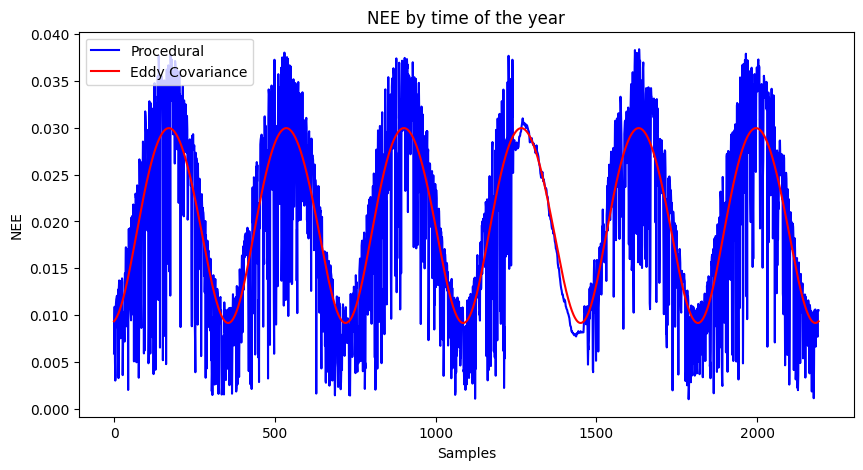

In [45]:
plot_against_time(sm_norm, obs_norm)

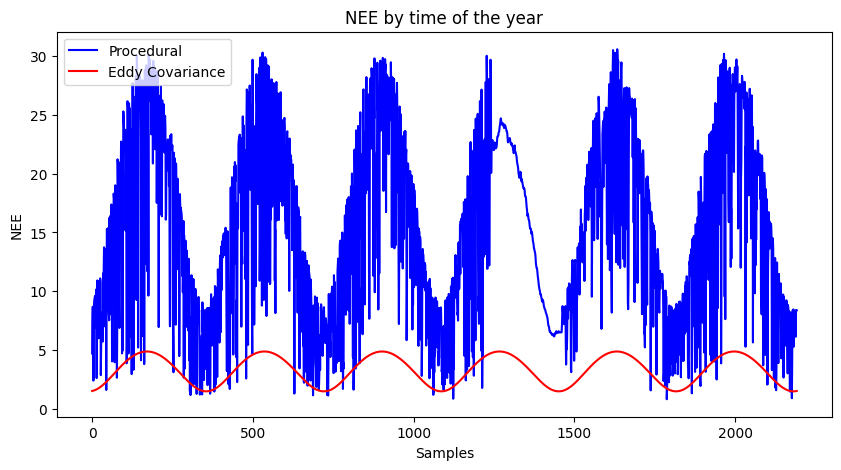

In [28]:
plot_against_time(df_irr['RADN'], df['SW_IN_POT']/ 100)

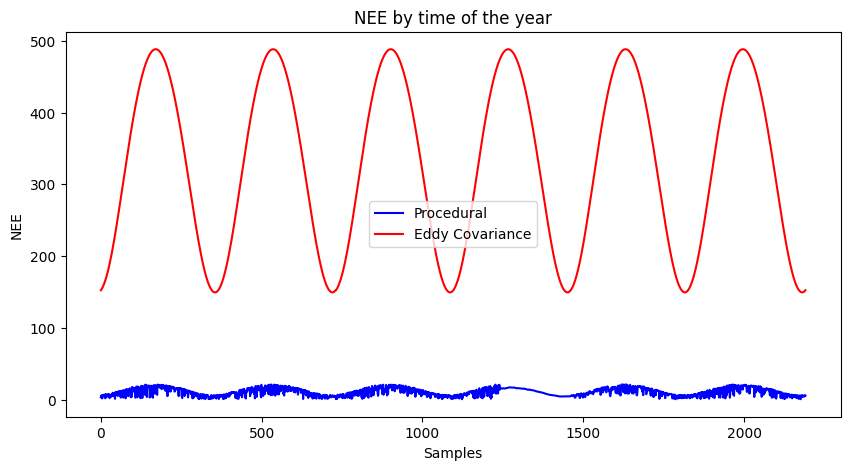

In [32]:
plot_against_time(df_irr['RADN'] , df['SW_IN_POT'])

In [63]:
get_most_similar(nee[:2192], nee_df, True)

{'JSD': {'NEE_VUT_REF_NIGHT_SD': 0.4564486398641424},
 'PRSN': {'NEE_CUT_05_NIGHT': 0.5844031376157531},
 'Cosine similarity': {'NEE_CUT_75_NIGHT': 0.5883954132109497},
 'K-Means': 'NEE_CUT_REF_NIGHT'}

In [67]:
get_most_similar(nee_d[:2192], nee_df, True)

{'JSD': {'NEE_VUT_REF_NIGHT_SD': 0.3951475827701259},
 'PRSN': {'NEE_VUT_16_NIGHT': 0.6829585823441287},
 'Cosine similarity': {'NEE_CUT_75_NIGHT': 0.7102379814996385},
 'K-Means': 'NEE_CUT_REF_NIGHT'}

In [11]:
df_irr = df_irr[:df.shape[0]]

In [12]:
extracted= {
'DATE': df['TIMESTAMP'],
'DOY' : df['DOY'],
'HMAX_AIR' :  df_irr['HMAX_AIR'], # dataset missing air humidity:/ 
'TMIN_AIR' : df['TA_ERA_NIGHT'], #TA_F_MDS also works
'TMAX_SOIL' : df['TS_F_MDS_7'] , #cosine and pearson agree
'HMIN_AIR' :  df_irr['HMIN_AIR'], #missing air humidity 
'TMAX_AIR' : df['TA_F_MDS'] ,
'RADN' : df['SW_IN_POT'],
'WIND' : df['WS_F'] ,
'D_W_PRECN' : df['P_F'], 
'TMIN_SOIL' : df_irr['TMIN_SOIL'], #observed data missing min soil temp
'NEE' : df['NEE_CUT_REF_NIGHT']
}

extracted_df = pd.DataFrame(extracted)

extracted_df.to_csv('../datasets/extractedNEE_CUT_REF_NIGHT_Final.csv')


In [13]:
extracted_df

,DATE,DOY,HMAX_AIR,TMIN_AIR,TMAX_SOIL,HMIN_AIR,TMAX_AIR,RADN,WIND,D_W_PRECN,TMIN_SOIL,NEE
0,2015-01-01,1,0.630569,-8.316,2.026,0.435766,-6.186,152.441,2.543,0.000,3.167734,0.728700
1,2015-01-02,2,0.630147,-6.127,2.148,0.349557,-5.299,153.067,1.614,0.000,2.970467,0.756333
2,2015-01-03,3,0.796492,-7.555,2.010,0.324438,-6.735,153.753,3.187,1.559,2.820677,0.717230
3,2015-01-04,4,0.897199,-14.733,1.373,0.501948,-15.570,154.497,4.039,1.094,3.144463,0.684707
4,2015-01-05,5,0.702206,-10.702,1.568,0.384053,-10.930,155.300,3.069,0.475,3.087650,0.850473
...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2020-12-27,362,0.835153,-2.049,1.892,0.441234,-0.632,150.527,3.471,0.939,3.194780,0.924725
2188,2020-12-28,363,0.835904,-4.516,1.782,0.423138,-3.868,150.916,1.893,0.001,3.187274,0.646184
2189,2020-12-29,364,0.784312,-3.835,1.678,0.363440,-3.761,151.365,3.063,15.407,3.110832,0.609222
2190,2020-12-30,365,0.696367,-8.046,1.588,0.271404,-6.133,151.874,2.707,0.000,2.867376,0.371313


In [60]:
df_irr['YEAR'] = df_irr['DATE'].dt.year

In [67]:
feats = extracted_df.columns
feats = feats.drop('NEE')

In [68]:
df_irr= df_irr[feats]

In [70]:
df_irr

,YEAR,DOY,HMAX_AIR,TMIN_AIR,TMAX_SOIL,HMIN_AIR,TMAX_AIR,RADN,WIND,D_W_PRECN,TMIN_SOIL
0,2015,1,0.630569,-2.93,4.434282,0.435766,2.91,4.710812,331.524,0.0,3.167734
1,2015,2,0.630147,-5.90,4.465995,0.349557,2.19,7.255759,247.068,0.0,2.970467
2,2015,3,0.796492,-6.89,5.164491,0.324438,9.11,8.689023,245.952,0.0,2.820677
3,2015,4,0.897199,-0.99,5.429086,0.501948,8.71,3.999532,376.056,0.7,3.144463
4,2015,5,0.702206,-4.64,4.190762,0.384053,3.73,2.409738,367.992,0.0,3.087650
...,...,...,...,...,...,...,...,...,...,...,...
2187,2020,362,0.835153,-2.76,5.151930,0.441234,15.86,6.271325,148.104,0.0,3.194780
2188,2020,363,0.835904,-3.33,4.810034,0.423138,7.20,6.136070,203.364,0.0,3.187274
2189,2020,364,0.784312,-5.38,5.533313,0.363440,9.37,8.411016,427.104,0.0,3.110832
2190,2020,365,0.696367,-9.23,5.226417,0.271404,8.29,8.372219,222.876,0.0,2.867376


In [14]:
filter_col = [col for col in df if col.startswith('TS') and not col.endswith('QC')]    

In [15]:
filter_col

['TS_F_MDS_1',
 'TS_F_MDS_2',
 'TS_F_MDS_3',
 'TS_F_MDS_4',
 'TS_F_MDS_5',
 'TS_F_MDS_6',
 'TS_F_MDS_7',
 'TS_F_MDS_8']

In [12]:
smallest_mean_for('TS', df)

'TS_F_MDS_3_QC'

In [11]:
df[filter_col].mean()

TS_F_MDS_1       11.348499
TS_F_MDS_2       11.334961
TS_F_MDS_3       12.403337
TS_F_MDS_4       11.385723
TS_F_MDS_5       11.384166
TS_F_MDS_6             NaN
TS_F_MDS_7       11.445622
TS_F_MDS_8       11.366537
TS_F_MDS_1_QC     0.999620
TS_F_MDS_2_QC     0.999563
TS_F_MDS_3_QC     0.876141
TS_F_MDS_4_QC     0.999639
TS_F_MDS_5_QC     0.999391
TS_F_MDS_6_QC          NaN
TS_F_MDS_7_QC     0.984824
TS_F_MDS_8_QC     0.999468
dtype: float64